In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import loadmat

In [2]:
data = loadmat('ex4data1.mat')
X = data['X']
y = data['y']

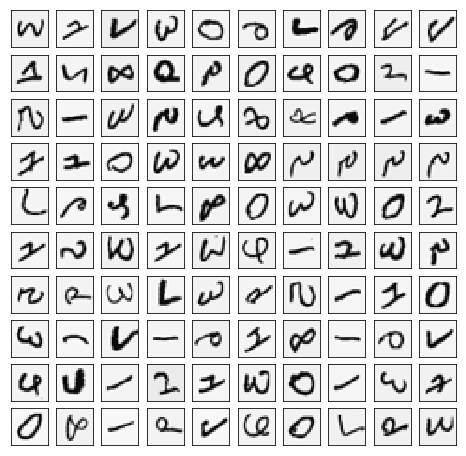

In [3]:
def plot100image():
    sampleIndex = np.random.choice(np.arange(X.shape[0]), 100)
    sample = X[sampleIndex]
    fig, ax = plt.subplots(nrows = 10, ncols = 10, sharex = True, sharey = True, figsize = (8, 8))
    for i in range(10):
        for j in range(10):
            temp = sample[10 * i + j]
            ax[i, j].matshow(temp.reshape(20, 20), cmap = 'gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()
plot100image()

In [4]:
X.shape, y.shape # 样本的输出是单独的一个数，应该改成10维的

((5000, 400), (5000, 1))

In [5]:
def expand_y(y): # 将y扩展 比如 y = 2 → y = [0, 1, 0, 0, ......]
    result = []
    for i in y:
        temp = np.zeros(10)
        temp[i - 1] = 1
        result.append(temp)
    
    return np.array(result)

In [6]:
X = np.insert(X, 0, 1, axis = 1)
y = expand_y(y)

In [7]:
X.shape, y.shape

((5000, 401), (5000, 10))

In [8]:
weight = loadmat('ex4weights.mat')
theta1 = weight['Theta1']
theta2 = weight['Theta2']
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [9]:
def serialize(a, b): # 展开参数
    return np.r_[a.flatten(), b.flatten()] # r_按行连接 c_按列连接

def deserialize(a):
    return a[ :25 * 401].reshape(25, 401), a[25 * 401: ].reshape(10, 26)

theta = serialize(theta1, theta2) # 将theta扁平化
theta.shape

(10285,)

In [10]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [11]:
def feedForward(theta, X):
    theta1, theta2 = deserialize(theta)
    a1 = X
    z2 = a1 @ theta1.T
    a2 = np.insert(sigmoid(z2), 0, 1, axis = 1)
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    return a1, z2, a2, z3, a3

In [12]:
def cost(theta, X, y):
    a1, z2, a2, z3, h = feedForward(theta, X) # h(Θ)是h, 也就是通过网络得到的结果
    J = 0
    for i in range(len(X)):
        first = -y[i] * np.log(h[i])
        second = -(1-y[i]) * np.log(1 - h[i])
        J += np.sum(first + second)
        
    J /= len(X)
    
    return J

In [13]:
cost(theta, X, y)

0.2876291651613187

In [14]:
def costReg(theta, X, y, l = 1):
    theta1, theta2 = deserialize(theta)
    first = np.sum(np.power(theta1[ : , 1: ], 2))
    second = np.sum(np.power(theta2[ : , 1: ], 2))
    return l / (2 * len(X)) * (first + second) + cost(theta, X, y)

In [15]:
costReg(theta, X, y)

0.3837698590909234

In [16]:
def sigmoidGradient(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [17]:
sigmoidGradient(0)

0.25

In [18]:
def randomInit(size):
    return np.random.uniform(-0.12, 0.12, size)

In [19]:
def gradientBackPropagation(theta, X, y): # 注意维度
    theta1, theta2 = deserialize(theta)
    a1, z2, a2, z3, a3 = feedForward(theta, X)
    delta3 = a3 - y
    delta2 = delta3 @ theta2[ : , 1: ] * sigmoidGradient(z2)
    D2 = delta3.T @ a2
    D1 = delta2.T @ a1
    return serialize(D1, D2) / len(X)

In [20]:
a1, z2, a2, z3, a3 = feedForward(theta, X)

In [21]:
def gradientChecking(theta, X, y, e):
    grads = []
    for i in range(len(theta)):
        a = theta.copy()
        b = theta.copy()
        a[i] = a[i] + e
        b[i] = b[i] - e
        tempgrad = (costReg(a, X, y) - costReg(b, X, y)) / (2 * e)
        grads.append(tempgrad)
    
    gradsArray = np.array(grads)
    gradient = gradientBackPropagation(theta, X, y)
    result = np.linalg.norm(gradsArray - gradient) / np.linalg.norm(gradsArray + gradient) # 将两个矩阵进行比较
    print(result) # 小于1e-9正确

In [22]:
# gradientChecking(theta, X, y, 0.0001) # 别跑 速度太慢 电脑烫

In [23]:
def gradientReg(theta, X, y, l = 1):
    a1, x2, a2, z3, a3 = feedForward(theta, X)
    D1, D2 = deserialize(gradientBackPropagation(theta, X, y))
    theta1, theta2 = deserialize(theta)
    D1Reg = D1 + l / len(X) * theta1
    D2Reg = D2 + l / len(X) * theta2
    return serialize(D1Reg, D2Reg)

In [24]:
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [25]:
def training(X, y):
    InitTheta = randomInit(10285)
    res = opt.minimize(fun = costReg, x0 = InitTheta, args = (X, y, 1), method = 'TNC', jac = gradientReg)
    return res

In [26]:
res = training(X, y)

In [27]:
res

     fun: 0.30678370250056963
     jac: array([ 1.26786907e-05,  7.85256582e-16, -2.12719287e-15, ...,
       -2.57912967e-07, -1.47477106e-06,  4.01211139e-08])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 2194
     nit: 96
  status: 1
 success: True
       x: array([-2.91922588e-01,  3.92628291e-12, -1.06359643e-11, ...,
       -2.97414292e+00, -5.02148433e-01, -5.94437865e-01])

In [28]:
def accuracy(theta, X, y):
    _, _, _, _, h = feedForward(res.x, X)
    y = data['y']
    y_pred = np.argmax(h, axis = 1) + 1
    print(classification_report(y, y_pred))

In [29]:
accuracy(theta, X, y)

              precision    recall  f1-score   support

           1       0.99      1.00      0.99       500
           2       1.00      1.00      1.00       500
           3       1.00      0.99      0.99       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       0.99      0.99      0.99       500
           8       1.00      1.00      1.00       500
           9       0.99      0.99      0.99       500
          10       0.99      1.00      1.00       500

   micro avg       1.00      1.00      1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



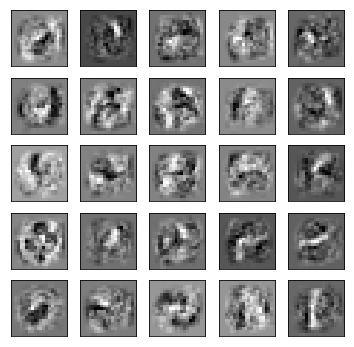

In [30]:
def plotHidden(theta):
    theta1, _ = deserialize(theta)
    theta1 = theta1[ : , 1: ]
    fig, ax = plt.subplots(nrows = 5, ncols = 5, sharex = True, sharey = True, figsize = (6, 6))
    for i in range(5):
        for j in range(5):
            temp = theta1[i * 5 + j]
            ax[i, j].matshow(temp.reshape(20, 20), cmap = 'gray_r')
    plt.xticks([])
    plt.yticks([])
    plt.show()
plotHidden(theta)